<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
```

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.
```python
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
```

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.
```python
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
```

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```
    
> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)
```

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).
```python
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(base_estimator=Tree(...), n_estimators=...)
```

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import RandomForestClassifier
model_unr = RandomForestClassifier(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model
```

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).
```python
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
```

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  
```python
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))
```

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.
```python
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()
```
    
>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.
```python
df = pd.read_csv("DailyDelhiClimateTest.csv")
```

<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*
---
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.

---
### Importante
* Esta pregunta será evaluada **sólo** por los resultados (*submission*) obtenidos en el desafío presentado en __[Kaggle](https://www.kaggle.com/c/t1-ml/)__ a través del siguiente __[link](https://www.kaggle.com/t/91f8c0c746f945cfa510b88469df4d67)__. Las notas serán entregadas a través de la siguiente fórmula:  
$$ Nota(i) = 100\cdot max\left(0.55; s^{(1-i)} \right), \ \ con \ \ i \in \{1,\ \ldots, N\}$$
Con la escala de decaimiento es $ s = 1.05$ y con $i$ su lugar en el *ranking*.

* La métrica de evaluación será el *f1 score* [[3]](#refs) sobre la clase positiva (*harassment*), así evaluar la calidad del modelo sobre la clase minoritaria, lo cual también debiera reflejar el desempeño de la clase negativa (al ser el complemento).
```python
from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')
```

* El archivo de *submission* debe contener las predicciones de *harassment* (0 o 1) a cada dato de pruebas, además de la columna de *id* asociado al dato, iniciando en 1. Si leyó de manera ordenada el archivo de pruebas, se puede generar de la siguiente manera:
```python
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)
```

* Se solicita realizar **un solo** *submission* por grupo, para no perjudicar la nota de sus compañeros en el *ranking*. Además de ser claros con sus nombres de entrega para no asignarles de manera errónea su correspondiente nota.

* **Si no realiza *submission* a Kaggle su nota en esta sección será de 0**.

* **Si su *score* alcanzado es menor o igual al *benchmark* random que se encuentra en el *ranking*, su nota en esta sección será de 25**

## 1. Ensamblados para regresión

In [1]:
import pandas as pd

#carga de datos y eliminación de la última columna
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [2]:
#separación de acuerdo a fecha y temporada

#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
df.drop(["date"], axis=1, inplace=True) #delete date


Luego de un análisis, se determina que al menos los factores más relevantes que influyen en la predicción de la temperatura ya se encuentran considerados, por lo que se decide no agregar más columnas.

In [3]:
#creación de conjuntos de validaión y entrenamiento


y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only


In [4]:
#exploración de los datos, de forma gráfica
import matplotlib.pyplot as plt


#sepración de series de acuerdo al año


thirteen=y[0:365]
fourteen=y[365:730]
fiveteen=y[730:1095]
sixteen=y[1095:1461]

mthirteen=df["month"][0:365]
mfourteen=df["month"][365:730]
mfiveteen=df["month"][730:1095]
msixteen=df["month"][1095:1461]
plt.figure(figsize=(15,7))
plt.plot(mthirteen,thirteen,label="2013")
plt.plot(mfourteen,fourteen,label="2014")
plt.plot(mfiveteen,fiveteen,label="2015")
plt.plot(msixteen,sixteen,label="2016")
plt.title('Temperatura a través de los meses en Delhi')
plt.xlabel('Mes')
plt.ylabel('Temperatura')
plt.legend()



Una vez definidos los conjuntos de datos a utilizar, y antes de pasar al desarrollo de modelos, se explora la forma en que se distribuyen los datos. Acá, como se cuenta con el año y mes en que una cierta medición de temperatura fue tomada, se realiza un gráfico en el que se separa por año el conjunto de datos, comparando en cada mes la temperatura obtenida en cada año, con lo que se pueden observar las variaciones para un mes en específico año a año. En este sentido, se puede notar claramente el progresivo aumento de las temperaturas, siendo esto más marcado en la temporada de verano, en la que en el año 2016 muy pocas veces se tuvieron temperaturas menores a 36°C, en comparación a años anteriores en los que en pocas ocasiones se superó este valor. Esta tendencia también se observa en las temporadas de invierno, donde las menores temperaturas se observaron en e año 2013.

In [5]:
#uso de arboles de decisión (regularizados y no regularizados)
import numpy as np


def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

from sklearn.tree import DecisionTreeRegressor as Tree

model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)


#definición de modelo regularizado, con min_samples_split=80
    
model_reg=Tree(min_samples_split=80)
model_reg.fit(X_train,y_train)



DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=80, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

En este caso, el rango de los datos está entre 20 y 25°C, por lo que por la forma en a que el modelo de árboles de decisión funciona, esta característica representa una ventaja, ya que permite obtener una mayor precisión en la predicción. Es por esto mismo que no es necesario realizar una escalabilidad en los datos, ya que, estadísticamente, los outliers no son muchos.

RMSE train=  0.0
RMSE val=  2.429667587088675


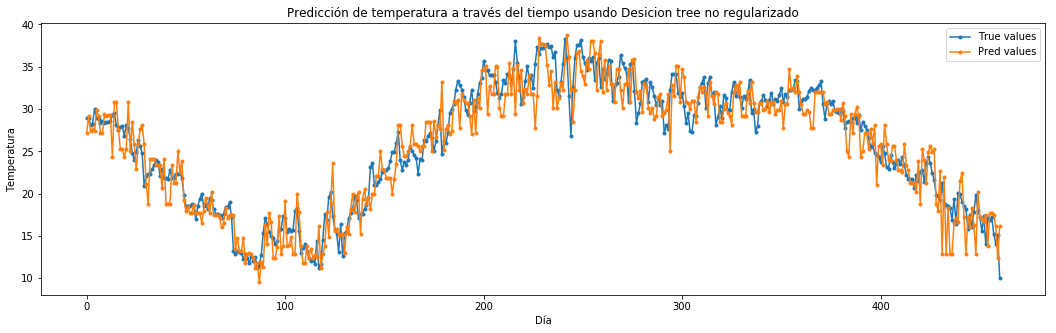

RMSE train=  1.6266177855516362
RMSE val=  1.6991037005187686


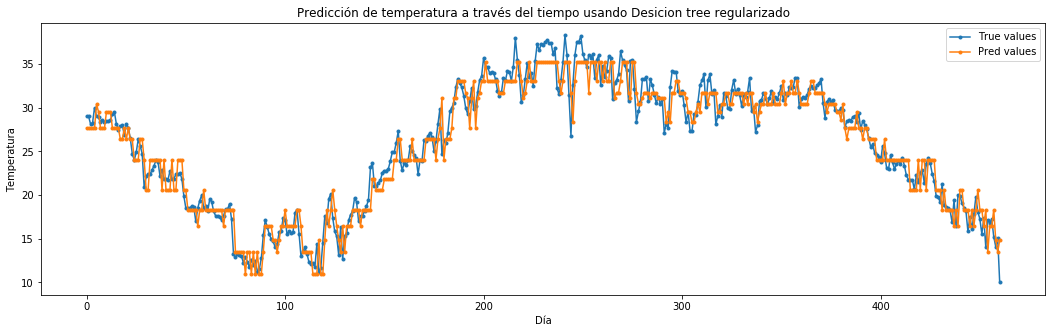

In [6]:
# Comparación a tavés del tiempo de regularizado vs no regularizado

y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(18,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.title('Predicción de temperatura a través del tiempo usando Desicion tree no regularizado')
plt.xlabel('Día')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

y_train_hat = model_reg.predict(X_train)
y_val_hat = model_reg.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(18,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.title('Predicción de temperatura a través del tiempo usando Desicion tree regularizado')
plt.xlabel('Día')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

En una primera instancia, observando solamente los valores de RMSE para los conjuntos de entrenamiento y validación en ambos modelos se puede notar que, en el caso de modelo no regularizado no hay error en el conjunto de entrenamiento, pero uno cercano a 2.6 en el conjunto de validación, por lo que existe un overfitting relativamente importante si s considera el rango de valores con los que se está trabajando, mientras que en el caso del modelo regularizado, existe error en ambos conjuntos, sin embargo, es menor al obtenido en el caso del modelo no regularizado, por lo que su overfitting es bastante menor al generado en ese modelo (alrededor de 0.07). Esta tendencia se  comprueba al observar los gráficos generados en ambos modelos, donde se nota claramente como en general, a través del tiempo, los valores obtenidos por el segundo modelo tienen una mayor similitud a los valores reales que los obtenidos en el primer modelo.

In [7]:
from sklearn.ensemble import BaggingRegressor

#modelo no regularizado
model_nr = BaggingRegressor(base_estimator=Tree(),n_estimators=10, n_jobs=-1)
model_nr.fit(X_train,y_train)
y_res_tr = model_nr.predict(X_train)
y_res_val = model_nr.predict(X_val)
print("RMSE train not reg des tree= ",RMSE(y_train,y_res_tr))
print("RMSE val not reg des tree= ",RMSE(y_val,y_res_val))
print("\n")

#modelo regularizado
model_r = BaggingRegressor(base_estimator=Tree(min_samples_split=80),n_estimators=10, n_jobs=-1)
model_r.fit(X_train,y_train)
y_res_tr = model_r.predict(X_train)
y_res_val = model_r.predict(X_val)
print("RMSE train reg des tree= ",RMSE(y_train,y_res_tr))
print("RMSE val reg des tree= ",RMSE(y_val,y_res_val))

RMSE train not reg des tree=  0.7621343722021986
RMSE val not reg des tree=  1.6977201333797243


RMSE train reg des tree=  1.6233403113111282
RMSE val reg des tree=  1.584302882371791


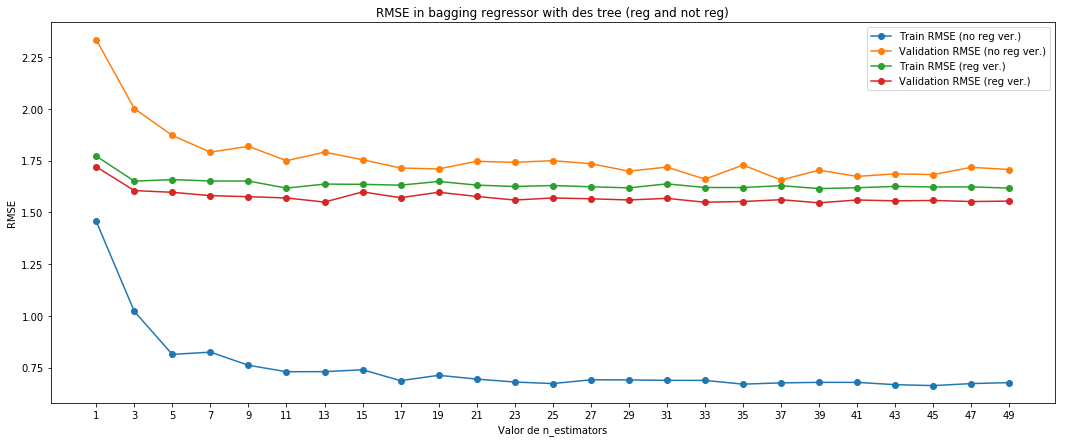

In [8]:
#definición de lista de valores a usar y variables

steps=2
n= np.arange(1, 51, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
rmse_tnr=[]
rmse_vnr=[]
rmse_tr=[]
rmse_vr=[]


#definición de funciones de ambos tipos de baggingregressor
def Do_bregnr(x,y,xv,yv,param):
    modell=BaggingRegressor(base_estimator=Tree(),n_estimators=param, n_jobs=-1)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    RMSE_t=RMSE(y,yres)
    RMSE_v=RMSE(yv,yresval)
    return RMSE_t,RMSE_v

def Do_bregr(x,y,xv,yv,param):
    modell=BaggingRegressor(base_estimator=Tree(min_samples_split=80),n_estimators=param, n_jobs=-1)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    RMSE_t=RMSE(y,yres)
    RMSE_v=RMSE(yv,yresval)
    return RMSE_t,RMSE_v
    
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_bregnr(X_train,y_train,X_val,y_val,i)
    rmr_t,rmr_v=Do_bregr(X_train,y_train,X_val,y_val,i)
    rmse_tnr.append(rm_t)
    rmse_vnr.append(rm_v)
    rmse_tr.append(rmr_t)
    rmse_vr.append(rmr_v)
    
#gráfico de rmse

plt.figure(figsize=(18,7))
plt.plot(rmse_tnr,marker="o")
plt.plot(rmse_vnr,marker="o")
plt.plot(rmse_tr,marker="o")
plt.plot(rmse_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('RMSE')
plt.xticks(range(len(n)), n)
plt.legend(['Train RMSE (no reg ver.)',"Validation RMSE (no reg ver.)","Train RMSE (reg ver.)","Validation RMSE (reg ver.)"])
plt.title('RMSE in bagging regressor with des tree (reg and not reg)')
plt.show()


De acuerdo con la teoría, en este caso lo que debería suceder es que el overfitting debería al menos disminuir, ya que se están usando varios modelos de un tipo anidados para generar una predicción de un valor, lo que claramente debería generar mejores resultados que utilizar un solo modelo del tipo elegido. En este caso, se observa claramente este comportamiento en el modelo que utiliza un árbol de decisión no regularizado, donde se disminuye de un overfitting superior a 2 a uno cercano a 1. En el caso del modelo regularizado, se genera underfitting en este caso, con un valor bastante similar al modelo anteriormente presentado, sin embargo, en ambos casos el error obtenido es menor, por lo que en ambos casos los modelos son mejores que los trabajados previamente.

Por otra parte, con respecto al gráfico en el que se presentan los diferentes valores de RMSE en el conjunto de entrenamiento y validación para ambos modelos desarrollados en esta etapa, se puede notar claramente que, al inicio, es decir antes de llegar a 9, existe una tendencia de disminuir el error al aumentar el valor de n_estimators, una vez pasado este valor se tiende a estabilizar el error. Sin embargo, en todos los casos presenta menores valores de overftting l modelo que utiliza árboles de decisión regularizados, por lo que se deduce que este es el mejor modelo entre ambos.

In [9]:
from sklearn.ensemble import AdaBoostRegressor


#modelos usando valores óptimos encontrados en el punto anterior

model_anr= AdaBoostRegressor(base_estimator=Tree(), n_estimators=13)
model_anr.fit(X_train,y_train)
y_res_tr = model_anr.predict(X_train)
y_res_val = model_anr.predict(X_val)
print("RMSE train not reg des tree= ",RMSE(y_train,y_res_tr))
print("RMSE val not reg des tree= ",RMSE(y_val,y_res_val))
print("\n")

model_ar= AdaBoostRegressor(base_estimator=Tree(min_samples_split=75), n_estimators=13)
model_ar.fit(X_train,y_train)
y_res_tr = model_ar.predict(X_train)
y_res_val = model_ar.predict(X_val)
print("RMSE train not reg des tree= ",RMSE(y_train,y_res_tr))
print("RMSE val not reg des tree= ",RMSE(y_val,y_res_val))
print("\n")

RMSE train not reg des tree=  0.14321002051994922
RMSE val not reg des tree=  1.9310513039989006


RMSE train not reg des tree=  1.4254341500714904
RMSE val not reg des tree=  1.6719362465670045




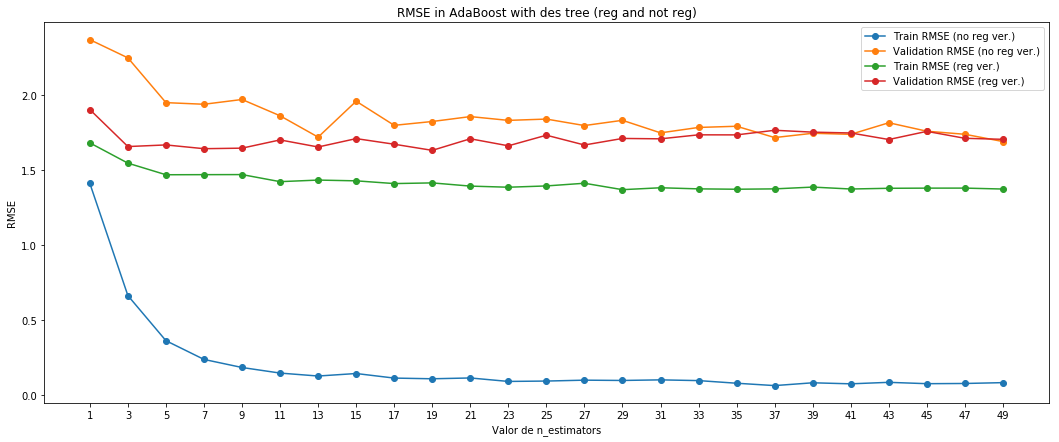

In [10]:
#definición de lista de valores a usar y variables

steps=2
n= np.arange(1, 51, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
rmse_tnr=[]
rmse_vnr=[]
rmse_tr=[]
rmse_vr=[]


#definición de funciones de ambos tipos de adaboostregressor
def Do_adanr(x,y,xv,yv,param):
    modell=AdaBoostRegressor(base_estimator=Tree(), n_estimators=param)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    RMSE_t=RMSE(y,yres)
    RMSE_v=RMSE(yv,yresval)
    return RMSE_t,RMSE_v

def Do_adar(x,y,xv,yv,param):
    modell=AdaBoostRegressor(base_estimator=Tree(min_samples_split=75),n_estimators=param)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    RMSE_t=RMSE(y,yres)
    RMSE_v=RMSE(yv,yresval)
    return RMSE_t,RMSE_v
    
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_adanr(X_train,y_train,X_val,y_val,i)
    rmr_t,rmr_v=Do_adar(X_train,y_train,X_val,y_val,i)
    rmse_tnr.append(rm_t)
    rmse_vnr.append(rm_v)
    rmse_tr.append(rmr_t)
    rmse_vr.append(rmr_v)
    
#gráfico de rmse

plt.figure(figsize=(18,7))
plt.plot(rmse_tnr,marker="o")
plt.plot(rmse_vnr,marker="o")
plt.plot(rmse_tr,marker="o")
plt.plot(rmse_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('RMSE')
plt.xticks(range(len(n)), n)
plt.legend(['Train RMSE (no reg ver.)',"Validation RMSE (no reg ver.)","Train RMSE (reg ver.)","Validation RMSE (reg ver.)"])
plt.title('RMSE in AdaBoost with des tree (reg and not reg)')
plt.show()

En primer lugar, se nota que, en el caso del modelo no regularizado, la cantidad de error obtenida es menor a la del modelo bagging regressor si se consideran por separado el error de entrenamiento y validación, sin embargo, el overfitting es aproximadamente mayor en 0.4. Un caso similar ocurre en el modelo regularizado, en el que, en el caso del error de entrenamiento, el error es bastante más bajo al del modelo bagging regressor, pero el overfitting obtenido es mucho mayor al de este modelo. Otro punto importante para destacar es que el valor óptimo de min_samples_split en este modelo es 75, no 80 como en el modelo anterior.

Por otra parte, de acuerdo con lo indicado en la descripción del modelo, sklearn utiliza activamente la técnica de pesar ejemplos, ya que a medida que se va iterando la muestra que se tiene se van ajustando los de acuerdo con los errores obtenidos en la iteración actual. De acuerdo con la forma en que funciona este modelo, debería funcionar mejor en general esta técnica, ya que existe una gran posibilidad de generar overfitting utilizando la otra.

En cuento al gráfico, en este se puede comprobar el análisis realizado en el primer párrafo, ya que generalmente los valores particulares de error en ciertos casos son menores a los del modelo de bagging regressor, sin embargo, en muchos casos es también mayor el overfitting.

In [11]:
#modelos usando valores óptimos encontrados en puntos anteriores

from sklearn.ensemble import RandomForestRegressor

model_unr = RandomForestRegressor(n_estimators=10, n_jobs=-1)
model_unr.fit(X_train,y_train)
y_res_tr = model_unr.predict(X_train)
y_res_val = model_unr.predict(X_val)
print("RMSE train not reg random forest= ",RMSE(y_train,y_res_tr))
print("RMSE val not reg random forest= ",RMSE(y_val,y_res_val))
print("\n")

model_r = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_split=75)
model_r.fit(X_train,y_train)
y_res_tr = model_r.predict(X_train)
y_res_val = model_r.predict(X_val)
print("RMSE train reg random forest= ",RMSE(y_train,y_res_tr))
print("RMSE val reg random forest= ",RMSE(y_val,y_res_val))

RMSE train not reg random forest=  0.7794303958412067
RMSE val not reg random forest=  1.7393687181427546


RMSE train reg random forest=  1.6013457905668196
RMSE val reg random forest=  1.5721836281932589


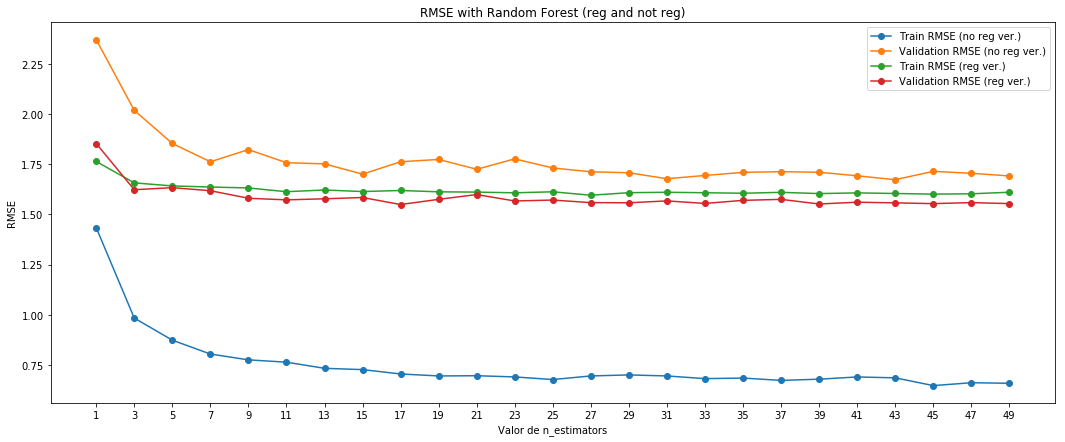

In [12]:
#definición de lista de valores a usar y variables

steps=2
n= np.arange(1, 51, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
rmse_tnr=[]
rmse_vnr=[]
rmse_tr=[]
rmse_vr=[]


#definición de funciones de ambos tipos de adaboostregressor
def Do_rfnr(x,y,xv,yv,param):
    modell=RandomForestRegressor(n_estimators=param, n_jobs=-1)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    RMSE_t=RMSE(y,yres)
    RMSE_v=RMSE(yv,yresval)
    return RMSE_t,RMSE_v

def Do_rfr(x,y,xv,yv,param):
    modell= RandomForestRegressor(n_estimators=param, n_jobs=-1, min_samples_split=75)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    RMSE_t=RMSE(y,yres)
    RMSE_v=RMSE(yv,yresval)
    return RMSE_t,RMSE_v
    
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_rfnr(X_train,y_train,X_val,y_val,i)
    rmr_t,rmr_v=Do_rfr(X_train,y_train,X_val,y_val,i)
    rmse_tnr.append(rm_t)
    rmse_vnr.append(rm_v)
    rmse_tr.append(rmr_t)
    rmse_vr.append(rmr_v)
    
#gráfico de rmse

plt.figure(figsize=(18,7))
plt.plot(rmse_tnr,marker="o")
plt.plot(rmse_vnr,marker="o")
plt.plot(rmse_tr,marker="o")
plt.plot(rmse_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('RMSE')
plt.xticks(range(len(n)), n)
plt.legend(['Train RMSE (no reg ver.)',"Validation RMSE (no reg ver.)","Train RMSE (reg ver.)","Validation RMSE (reg ver.)"])
plt.title('RMSE with Random Forest (reg and not reg)')
plt.show()

En este caso, se puede notar que los valores obtenidos utilizando los parámetros que han entregado buenos resultados en otras ocasiones son muy similares al mejor de los modelos obtenidos, teniendo ligeras variaciones en el primer modelo (no regularizado), y siendo un poco más notorias en el segundo (teniendo a disminuir el underfitting y el error en general). Sin embargo, la forma en los gráficos es bastante diferente a la observada en los casos anteriores, ya que por ejemplo, los valores de error del conjunto de validación en el modelo no regularizado se encuentran en un rango mucho menor que en casos anteriores, así mismo los valores tienden a lo largo del gráfico a mantenerse en un cierto rango sin tener muchos cambios drásticos. Todo esto sumado contribuye a que este modelo, en general, sea ligeramente mejor a los dos anteriores trabajados, ya que disminuye el error sin aumentar el overfitting, en general.

In [13]:
#uso de error OOB

model_r = RandomForestRegressor(n_estimators=49, n_jobs=-1, min_samples_split=75,oob_score=True)
model_r.fit(X_train,y_train)
oob_error = model_r.oob_score_
val_error = model_r.score(X_val,y_val)
print("OOB error ( regulized random forest): ",oob_error)
print ("Val error ( regulized random forest): ",val_error)

model_br = BaggingRegressor(base_estimator=Tree(min_samples_split=80),n_estimators=31, n_jobs=-1,oob_score=True)
model_br.fit(X_train,y_train)
oob_error = model_br.oob_score_
val_error = model_br.score(X_val,y_val)
print("OOB error ( regulized bagging regression): ",oob_error)
print ("Val error ( regulized bagging regression): ",val_error)

OOB error ( regulized random forest):  0.9440474368070941
Val error ( regulized random forest):  0.9517312161333207
OOB error ( regulized bagging regression):  0.9436000210494747
Val error ( regulized bagging regression):  0.9512028682532713


Al comparar el error obtenido mediante OOB con el score simple, se puede notar que es posible que OOB entregue un valor más cercano a la realidad, ya que los valores son aproximadamente 0.01 menores a los entregados por score simple. Además, mediante OOB se puede observar de forma más realista la diferencia existente entre ambos modelos, que, a pesar de ser muy ligera, puede representar una diferencia en la perfomance de ambos modelos, de acuerdo a esto el modelo de regulized random forest es  mejor que el modelo regulized bagging regression.

In [14]:
#se define de forma que se entrega la mediana al combinar predicciones
def combine_predictions(predictions):
    pred=[]
    for i in range (0,len(predictions[0])):
        tot=[]
        for prediction in predictions:
            tot.append(prediction[i])
        pred.append(np.median(np.asarray(tot)))
    return np.asarray(pred)
list_estimators = model_br.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
list_predictions_t = [estimator.predict(X_train) for estimator in list_estimators]
new_predictions_t = combine_predictions(list_predictions_t)

print("RMSE train= ",RMSE(y_train, new_predictions_t))
print("RMSE val= ",RMSE(y_val, new_predictions))


RMSE train=  1.6628910004627477
RMSE val=  1.5831486363664264


En este caso, al utilizar el valor de mediana para realiza la mezcla de los clasificadores, utilizando el modelo de bagging regression regularizado, se obtienen valores de error bastante similares a los ya obtenidos anteriormente, aumentando un poco el overfitting, por lo que, en este caso, no existe una gran cantidad de resultados atípicos, sin embargo, esta opción de todas formas puede ser considerada como un buen modelo, ya que entrega buenos valores de error.

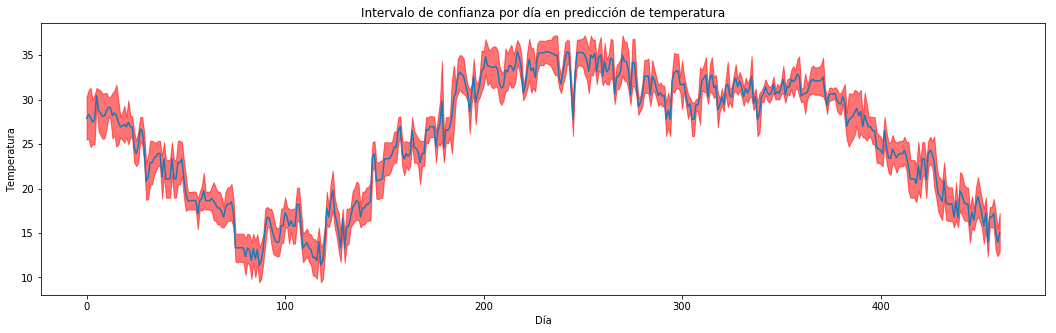

In [15]:
#en base a lo explorado anteriormente, se define un modelo con más de 100 modelos internos

model_r = RandomForestRegressor(n_estimators=101, n_jobs=-1, min_samples_split=75,oob_score=True)
model_r.fit(X_train,y_train)
list_estimators = model_r.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(18,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.xlabel('Día')
plt.ylabel('Temperatura')
plt.title('Intervalo de confianza por día en predicción de temperatura')
plt.show()

Al realizar el gráfico de intervalo de confianza de acuerdo a cada uno de los valores a predecir se puede notar que, de forma general, los valores que incluyen un intervalo de confianza más amplio se encuentran en el medio, es decir entre los días 200 y 240 aproximadamente, lo que inluye en la forma en la que se realiza la predicción y finalmente en el valor predicho, generando una mayor probabilidad de tener error en ese sector.

In [16]:
#carga de datos de testing

df = pd.read_csv("DailyDelhiClimateTest.csv")
df["y_value"] = df["meantemp"].shift(-1)
#df = df.iloc[:-1] #remove last row

#separación de acuerdo a fecha y temporada

#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
df['season_fall'] = 0 #no hay datos de estos meses, por lo que debe agregarse la columna
df['season_rainy'] = 0 #no hay datos de estos meses, por lo que debe agregarse la columna
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
seasons = ["winter","winter","summer","summer"]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
df.drop(["date"], axis=1, inplace=True) #delete date



In [17]:
y_test = df.pop("y_value").values[0:113]
X_test = df.values[0:113]

#la última columna tiene un error


np.any(np.isnan(X_test))

np.all(np.isfinite(y_test))
np.all(np.isfinite(X_test))

#se elige como mejor modelo regulized random forest

model_r = RandomForestRegressor(n_estimators=49, n_jobs=-1, min_samples_split=75,oob_score=True)
model_r.fit(X_train,y_train)
oob_error = model_r.oob_score_
val_error = model_r.score(X_test,y_test)
print("OOB error ( regulized random forest): ",oob_error)
print ("Test error ( regulized random forest): ",val_error)
y_res_t = model_ar.predict(X_test)
print("RMSE test reg random forest= ",RMSE(y_test,y_res_t))

OOB error ( regulized random forest):  0.9444863532593846
Test error ( regulized random forest):  0.9308598990924534
RMSE test reg random forest=  1.836327263160461


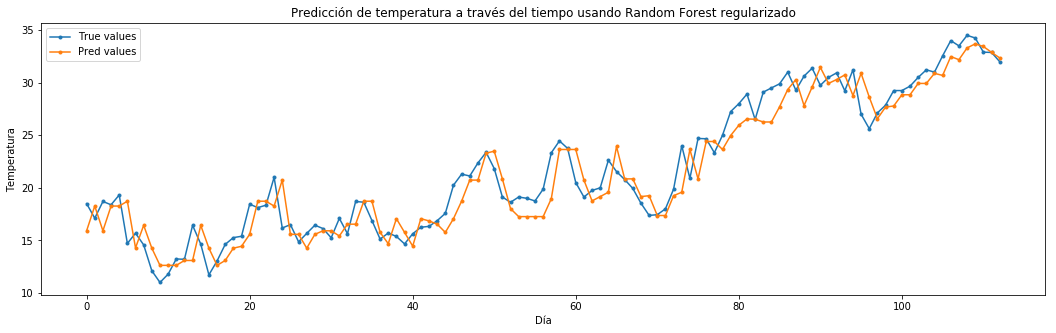

In [18]:
plt.figure(figsize=(18,5))
plt.plot(y_test, '.-' ,label="True values")
plt.plot(y_res_t, '.-' ,label="Pred values")
plt.title('Predicción de temperatura a través del tiempo usando Random Forest regularizado')
plt.xlabel('Día')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

Los resultados obtenidos con el mejor modelo en el conjunto de prueba son un tanto peores a los obtenidos en el conjunto de validación, lo que se puede notar en el gráfico presentado y en los valores de score y RMSE. En el gráfico se observa la cercanía de la curva de valores obtenidos a los valores reales, pero notando que en pocos casos el valor coincide en ambas curvas, lo que implica que el error obtenido está asociado a esto mismo, sin embargo, este es mínimo comparado a otros posibles modelos, por lo tanto, el modelo encontrado resulta ser un buen predictor finalmente.

Por otra parte, con respecto a las otras maneras, aunque tuvieron un error mayor a este, no son modelos que son totalmente inválidos, sobre todo si se utilizan los parámetros adecuados, es por esto que resulta de vital importancia realizar gráficos similares a los desarrollados acá en este tipo de problemas, ya que permite tener una mayor cercanía a lo que está ocurriendo internamente en el modelo y la forma en la que se llega al error que se obtiene.

Finalmente, un punto importante a mencionar es el tipo de error utilizado en estos casos, ya que en este caso el score simple no entrega información relevante respecto al error, por la forma en la que se realiza la predicción en los modelos, y también por ser un problema de regresión. En este sentido, el error RMSE utilizado en este caso representa una buena opción, la que puede ser complementada en gran medida si se considera un gráfico donde se muestren los intervalos de confianza, sobre todo si se busca mejorar e modelo al conocer la forma en que este opera internamente

<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*

In [19]:
from  sklearn.metrics import f1_score



In [20]:
#carga de datos
import pandas as pd

df = pd.read_csv("Train_data.csv")
ts= pd.read_csv("Test_input.csv")

#ordenar datos por columna
df=df = df.sort_values(by=["id"])

id_test=ts["id"]

texts_one=df["tweet_content"]
test_text=ts["tweet_content"]

harass_one=df["harassment"]

In [21]:
#separación de conjuntos (train,val,test)

"se separan 1000 para validación"

from sklearn.model_selection import train_test_split
df_train_text, df_val_text, labels_train, labels_val  = train_test_split(texts_one, harass_one, test_size=1000, random_state=0)

In [22]:
#normalización de texto

import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in test_text]

In [23]:
#representación en TF

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#train
vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(texts_train)
features_train = vectorizer.transform(texts_train)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

#val
features_val = vectorizer.transform(texts_val)
vocab_v = vectorizer.get_feature_names()
distval=list(np.array(features_val.sum(axis=0)).reshape(-1,))

#test
features_test = vectorizer.transform(texts_test)
vocab_t = vectorizer.get_feature_names()
distest=list(np.array(features_test.sum(axis=0)).reshape(-1,))

c:\users\samuel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


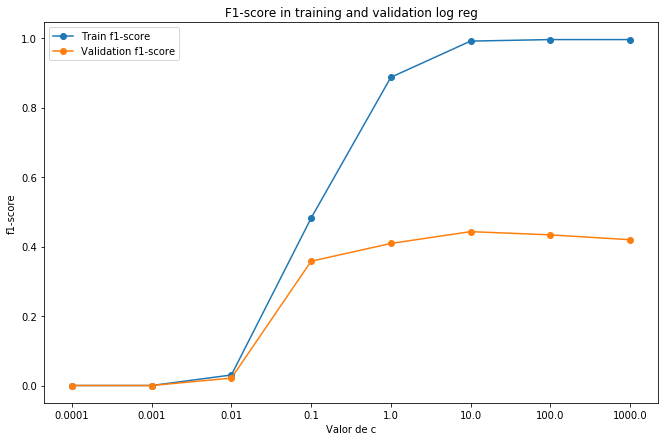

In [24]:
#regularización
import matplotlib.pyplot as plt



from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv, param):
    model= LogisticRegression(solver='liblinear')
    model.set_params(C=param)
    model.fit(x,y)
    y_pred_t=model.predict(x)
    y_pred_v=model.predict(xv)
    train_f1 =f1_score(y, y_pred_t, average='binary')
    test_f1 = f1_score(yv, y_pred_v, average='binary')
    return model, train_f1, test_f1
Cs = [10**i for i in np.arange(-4,4, dtype=float)]

acc_t=[]
acc_v=[]
for i in Cs:
    model, train_acc, test_acc = do_LOGIT(features_train,labels_train,features_val,labels_val, param= i)
    acc_t.append(train_acc)
    acc_v.append(test_acc)
    
#grafico de f1-score en entrenamiento y valudacion
plt.figure(figsize=(11,7))
plt.plot(acc_t,marker="o")
plt.plot(acc_v,marker="o")
plt.xlabel('Valor de c')
plt.ylabel('f1-score')
plt.xticks(range(len(Cs)), Cs)
plt.legend(['Train f1-score',"Validation f1-score"])
plt.title('F1-score in training and validation log reg')
plt.show()

In [25]:
#prueba con árboles de desición
#part 1:no regularizado

from sklearn.tree import DecisionTreeClassifier as Tre

model_unr=Tre()
model_unr.fit(features_train,labels_train)
y_tr=model_unr.predict(features_train)
y_vl=model_unr.predict(features_val)
train_f1 =f1_score(labels_train, y_tr, average='binary')
val_f1 = f1_score(labels_val, y_vl, average='binary')

print("F1-score train:", train_f1)
print("F1-score val:", val_f1)


F1-score train: 0.9955947136563876
F1-score val: 0.40268456375838924


In [26]:
#part 2:regulized

model_r=Tre(min_samples_split=3000)
model_r.fit(features_train,labels_train)
y_tr=model_r.predict(features_train)
y_vl=model_r.predict(features_val)
train_f1 =f1_score(labels_train, y_tr, average='binary')
val_f1 = f1_score(labels_val, y_vl, average='binary')

print("F1-score train:", train_f1)
print("F1-score val:", val_f1)

F1-score train: 0.6186726659167604
F1-score val: 0.4482758620689655


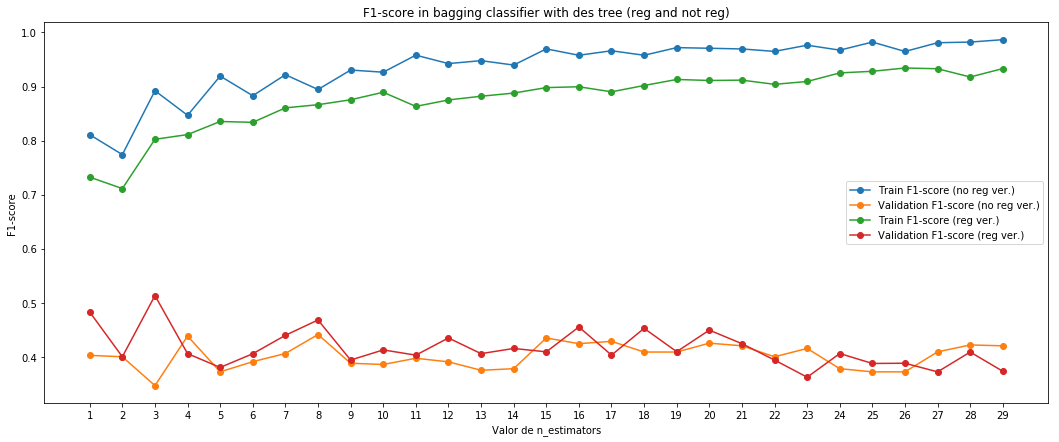

In [27]:
#bagging classifier!!

from sklearn.ensemble import BaggingClassifier

#definición de lista de valores a usar y variables

steps=1
n= np.arange(1, 30, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
f1_tnr=[]
f1_vnr=[]
f1_tr=[]
f1_vr=[]


#definición de funciones de ambos tipos de baggingclassifier
def Do_bclanr(x,y,xv,yv,param):
    modell=BaggingClassifier(base_estimator=Tre(),n_estimators=param, n_jobs=-1)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    f1_t=f1_score(y, yres, average='binary')
    f1_v=f1_score(yv,yresval,average="binary")
    return f1_t,f1_v

def Do_bclar(x,y,xv,yv,param):
    modell=BaggingClassifier(base_estimator=Tre(min_samples_split=40),n_estimators=param, n_jobs=-1)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    f1_t=f1_score(y, yres, average='binary')
    f1_v=f1_score(yv,yresval,average="binary")
    return f1_t,f1_v
    
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_bclanr(features_train,labels_train,features_val,labels_val,i)
    rmr_t,rmr_v=Do_bclar(features_train,labels_train,features_val,labels_val,i)
    f1_tnr.append(rm_t)
    f1_vnr.append(rm_v)
    f1_tr.append(rmr_t)
    f1_vr.append(rmr_v)
    
#gráfico de f1_score

plt.figure(figsize=(18,7))
plt.plot(f1_tnr,marker="o")
plt.plot(f1_vnr,marker="o")
plt.plot(f1_tr,marker="o")
plt.plot(f1_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('F1-score')
plt.xticks(range(len(n)), n)
plt.legend(['Train F1-score (no reg ver.)',"Validation F1-score (no reg ver.)","Train F1-score (reg ver.)","Validation F1-score (reg ver.)"])
plt.title('F1-score in bagging classifier with des tree (reg and not reg)')
plt.show()


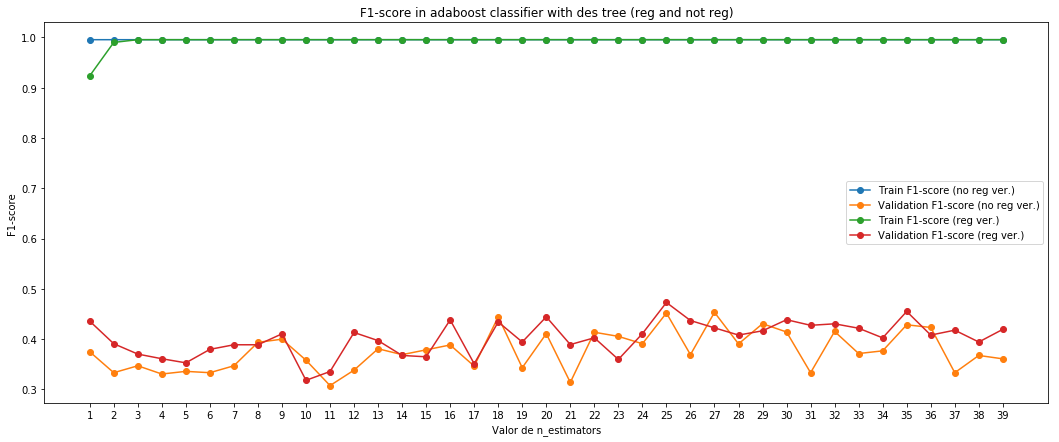

In [28]:
#adaboost classifier!!

from sklearn.ensemble import AdaBoostClassifier

#definición de lista de valores a usar y variables

steps=1
n= np.arange(1, 40, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
f1_tnr=[]
f1_vnr=[]
f1_tr=[]
f1_vr=[]


#definición de funciones de ambos tipos de baggingclassifier
def Do_adclanr(x,y,xv,yv,param):
    modell=AdaBoostClassifier(base_estimator=Tre(),n_estimators=param)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    f1_t=f1_score(y, yres, average='binary')
    f1_v=f1_score(yv,yresval,average="binary")
    return f1_t,f1_v

def Do_adclar(x,y,xv,yv,param):
    modell=AdaBoostClassifier(base_estimator=Tre(min_samples_split=30),n_estimators=param)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    f1_t=f1_score(y, yres, average='binary')
    f1_v=f1_score(yv,yresval,average="binary")
    return f1_t,f1_v
    
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_adclanr(features_train,labels_train,features_val,labels_val,i)
    rmr_t,rmr_v=Do_adclar(features_train,labels_train,features_val,labels_val,i)
    f1_tnr.append(rm_t)
    f1_vnr.append(rm_v)
    f1_tr.append(rmr_t)
    f1_vr.append(rmr_v)
    
#gráfico de f1_score

plt.figure(figsize=(18,7))
plt.plot(f1_tnr,marker="o")
plt.plot(f1_vnr,marker="o")
plt.plot(f1_tr,marker="o")
plt.plot(f1_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('F1-score')
plt.xticks(range(len(n)), n)
plt.legend(['Train F1-score (no reg ver.)',"Validation F1-score (no reg ver.)","Train F1-score (reg ver.)","Validation F1-score (reg ver.)"])
plt.title('F1-score in adaboost classifier with des tree (reg and not reg)')
plt.show()


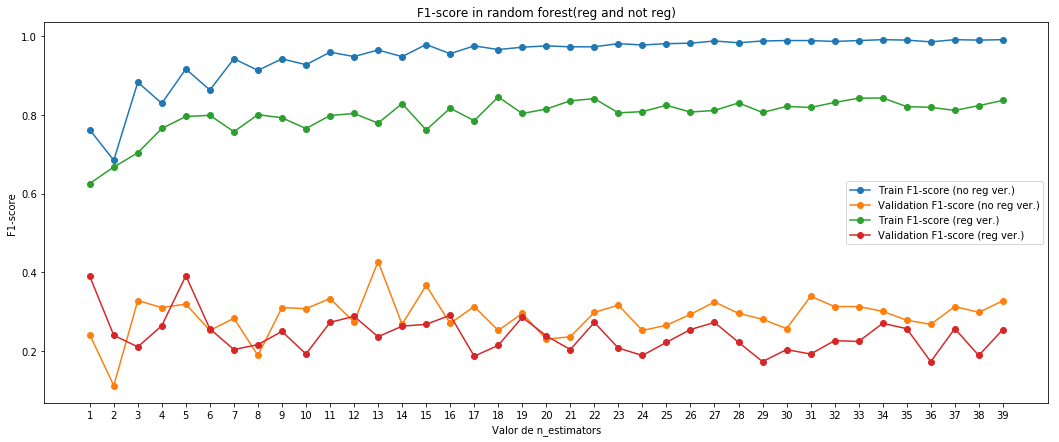

In [29]:
#random forest classifier!!

from sklearn.ensemble import RandomForestClassifier

#definición de lista de valores a usar y variables

steps=1
n= np.arange(1, 40, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
f1_tnr=[]
f1_vnr=[]
f1_tr=[]
f1_vr=[]


#definición de funciones de ambos tipos de baggingclassifier
def Do_rfclanr(x,y,xv,yv,param):
    modell=RandomForestClassifier(n_estimators=param, n_jobs=-1)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    f1_t=f1_score(y, yres, average='binary')
    f1_v=f1_score(yv,yresval,average="binary")
    return f1_t,f1_v

def Do_rfclar(x,y,xv,yv,param):
    modell=RandomForestClassifier(n_estimators=param, n_jobs=-1,min_samples_split=30)
    modell.fit(x,y)
    yres = modell.predict(x)
    yresval = modell.predict(xv)
    f1_t=f1_score(y, yres, average='binary')
    f1_v=f1_score(yv,yresval,average="binary")
    return f1_t,f1_v
    
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_rfclanr(features_train,labels_train,features_val,labels_val,i)
    rmr_t,rmr_v=Do_rfclar(features_train,labels_train,features_val,labels_val,i)
    f1_tnr.append(rm_t)
    f1_vnr.append(rm_v)
    f1_tr.append(rmr_t)
    f1_vr.append(rmr_v)
    
#gráfico de rmse

plt.figure(figsize=(18,7))
plt.plot(f1_tnr,marker="o")
plt.plot(f1_vnr,marker="o")
plt.plot(f1_tr,marker="o")
plt.plot(f1_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('F1-score')
plt.xticks(range(len(n)), n)
plt.legend(['Train F1-score (no reg ver.)',"Validation F1-score (no reg ver.)","Train F1-score (reg ver.)","Validation F1-score (reg ver.)"])
plt.title('F1-score in random forest(reg and not reg)')
plt.show()

In [30]:
#cambio en representación buscando mejorar resultados
from nltk.stem.porter import PorterStemmer

#se parte realizando un proceso similar al realizado en c, pero ahora con wordstemmer
def st_word(wor):
    wordstemmer = PorterStemmer()
    return wordstemmer.stem(wor)

def word_extractor_2(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ st_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if (word not in commonwords and (not word.isdigit())): #delete stopwords
            words+=" "+word
    return words

n_train = [word_extractor_2(text) for text in df_train_text]
n_val = [word_extractor_2(text) for text in df_val_text]
n_test = [word_extractor_2(text) for text in test_text]

In [31]:
#TF representation

#train
vectorizern = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizern.fit(n_train)
featuresN_train = vectorizern.transform(n_train)
vocabN = vectorizern.get_feature_names()

#val
featuresN_val = vectorizern.transform(n_val)
vocabN_v = vectorizern.get_feature_names()

#test
featuresN_test = vectorizern.transform(n_test)
vocabN_t = vectorizern.get_feature_names()

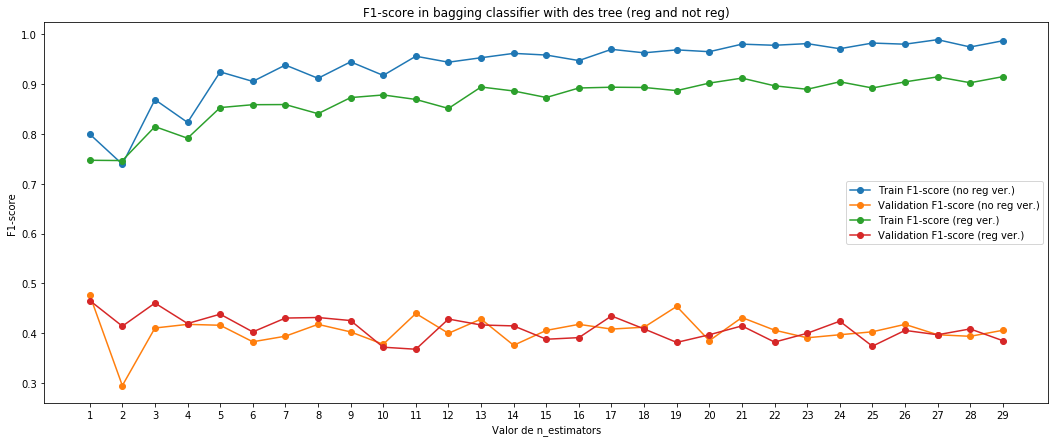

In [32]:
#new bagging graph

steps=1
n= np.arange(1, 30, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
f1_tnr=[]
f1_vnr=[]
f1_tr=[]
f1_vr=[]

#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_bclanr(featuresN_train,labels_train,featuresN_val,labels_val,i)
    rmr_t,rmr_v=Do_bclar(featuresN_train,labels_train,featuresN_val,labels_val,i)
    f1_tnr.append(rm_t)
    f1_vnr.append(rm_v)
    f1_tr.append(rmr_t)
    f1_vr.append(rmr_v)
    
#gráfico de f1_score

plt.figure(figsize=(18,7))
plt.plot(f1_tnr,marker="o")
plt.plot(f1_vnr,marker="o")
plt.plot(f1_tr,marker="o")
plt.plot(f1_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('F1-score')
plt.xticks(range(len(n)), n)
plt.legend(['Train F1-score (no reg ver.)',"Validation F1-score (no reg ver.)","Train F1-score (reg ver.)","Validation F1-score (reg ver.)"])
plt.title('F1-score in bagging classifier with des tree (reg and not reg)')
plt.show()

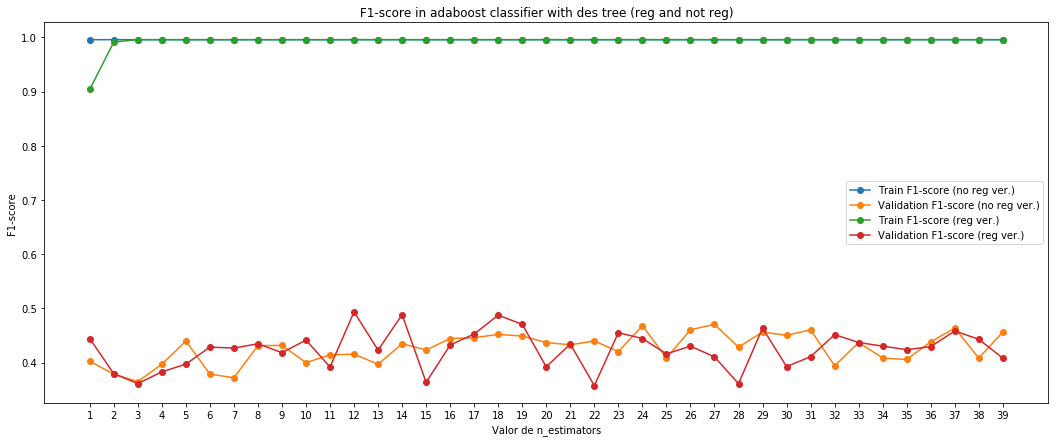

In [33]:
#new adaboost

steps=1
n= np.arange(1, 40, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
f1_tnr=[]
f1_vnr=[]
f1_tr=[]
f1_vr=[]
#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_adclanr(featuresN_train,labels_train,featuresN_val,labels_val,i)
    rmr_t,rmr_v=Do_adclar(featuresN_train,labels_train,featuresN_val,labels_val,i)
    f1_tnr.append(rm_t)
    f1_vnr.append(rm_v)
    f1_tr.append(rmr_t)
    f1_vr.append(rmr_v)
    
#gráfico de f1_score

plt.figure(figsize=(18,7))
plt.plot(f1_tnr,marker="o")
plt.plot(f1_vnr,marker="o")
plt.plot(f1_tr,marker="o")
plt.plot(f1_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('F1-score')
plt.xticks(range(len(n)), n)
plt.legend(['Train F1-score (no reg ver.)',"Validation F1-score (no reg ver.)","Train F1-score (reg ver.)","Validation F1-score (reg ver.)"])
plt.title('F1-score in adaboost classifier with des tree (reg and not reg)')
plt.show()

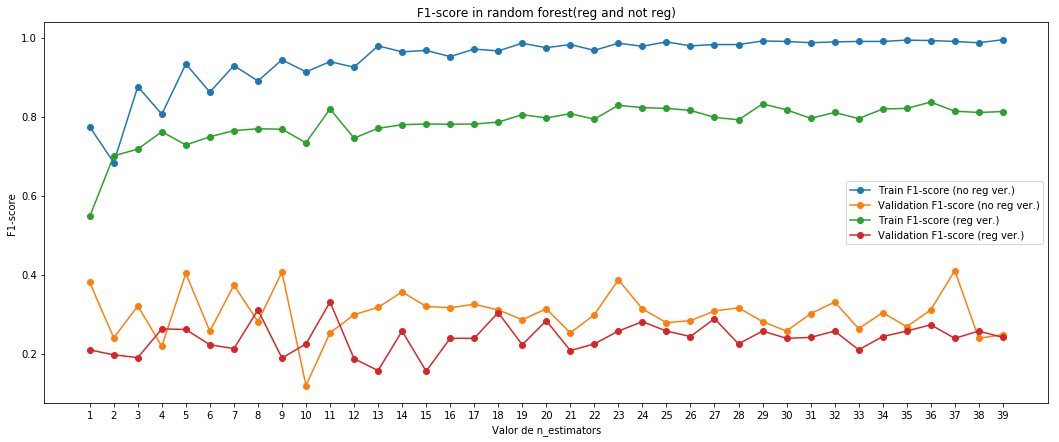

In [34]:
#new random forest

steps=1
n= np.arange(1, 40, steps) #ajuste de tamaño de auerdo a cantidad de datos de entrenaminto
f1_tnr=[]
f1_vnr=[]
f1_tr=[]
f1_vr=[]

#iteracion sobre conjunto de valores de lista
for i in n:
    rm_t,rm_v=Do_rfclanr(featuresN_train,labels_train,featuresN_val,labels_val,i)
    rmr_t,rmr_v=Do_rfclar(featuresN_train,labels_train,featuresN_val,labels_val,i)
    f1_tnr.append(rm_t)
    f1_vnr.append(rm_v)
    f1_tr.append(rmr_t)
    f1_vr.append(rmr_v)
    
#gráfico de rmse

plt.figure(figsize=(18,7))
plt.plot(f1_tnr,marker="o")
plt.plot(f1_vnr,marker="o")
plt.plot(f1_tr,marker="o")
plt.plot(f1_vr,marker="o")
plt.xlabel('Valor de n_estimators')
plt.ylabel('F1-score')
plt.xticks(range(len(n)), n)
plt.legend(['Train F1-score (no reg ver.)',"Validation F1-score (no reg ver.)","Train F1-score (reg ver.)","Validation F1-score (reg ver.)"])
plt.title('F1-score in random forest(reg and not reg)')
plt.show()

In [35]:
#definición de mejor modelo elegido entre los probados

#type 1

#features_train,labels_train,features_val,labels_val

modell=BaggingClassifier(base_estimator=Tre(min_samples_split=40),n_estimators=4, n_jobs=-1)
modell.fit(features_train,labels_train)
yres = modell.predict(features_train)
yresval = modell.predict(features_val)
f1_t=f1_score(labels_train, yres, average='binary')
f1_v=f1_score(labels_val,yresval,average="binary")
print ("F1-score bagging classifier (reg) ver 1 TRAIN: ",f1_t)
print ("F1-score bagging classifier (reg) ver 1 VAL: ",f1_v)
print("Overfitting:", f1_t-f1_v)
print("\n")

modell=AdaBoostClassifier(base_estimator=Tre(min_samples_split=40),n_estimators=30)
modell.fit(features_train,labels_train)
yres = modell.predict(features_train)
yresval = modell.predict(features_val)
f1_t=f1_score(labels_train, yres, average='binary')
f1_v=f1_score(labels_val,yresval,average="binary")
print ("F1-score adaboost classifier (reg) ver 1 TRAIN: ",f1_t)
print ("F1-score adaboost classifier (reg) ver 1 VAL: ",f1_v)
print("Overfitting:", f1_t-f1_v)
print("\n")

modell=RandomForestClassifier(n_estimators=11, n_jobs=-1)
modell.fit(features_train,labels_train)
yres = modell.predict(features_train)
yresval = modell.predict(features_val)
f1_t=f1_score(labels_train, yres, average='binary')
f1_v=f1_score(labels_val,yresval,average="binary")
print ("F1-score random forest classifier (reg) ver 1 TRAIN: ",f1_t)
print ("F1-score random forest classifier (reg) ver 1 VAL: ",f1_v)
print("Overfitting:", f1_t-f1_v)
print("\n")

#type 2

modell=BaggingClassifier(base_estimator=Tre(min_samples_split=40),n_estimators=4, n_jobs=-1)
modell.fit(featuresN_train,labels_train)
yres = modell.predict(featuresN_train)
yresval = modell.predict(featuresN_val)
f1_t=f1_score(labels_train, yres, average='binary')
f1_v=f1_score(labels_val,yresval,average="binary")
print ("F1-score bagging classifier (reg) ver 2 TRAIN: ",f1_t)
print ("F1-score bagging classifier (reg) ver 2 VAL: ",f1_v)
print("Overfitting:", f1_t-f1_v)
print("\n")

modell=AdaBoostClassifier(base_estimator=Tre(min_samples_split=48),n_estimators=19)
modell.fit(featuresN_train,labels_train)
yres = modell.predict(featuresN_train)
yresval = modell.predict(featuresN_val)
f1_t=f1_score(labels_train, yres, average='binary')
f1_v=f1_score(labels_val,yresval,average="binary")
print ("F1-score adaboost classifier (reg) ver 2 TRAIN: ",f1_t)
print ("F1-score adaboost classifier (reg) ver 2 VAL: ",f1_v)
print("Overfitting:", f1_t-f1_v)
print("\n")

modell=RandomForestClassifier(n_estimators=5, n_jobs=-1)
modell.fit(featuresN_train,labels_train)
yres = modell.predict(featuresN_train)
yresval = modell.predict(featuresN_val)
f1_t=f1_score(labels_train, yres, average='binary')
f1_v=f1_score(labels_val,yresval,average="binary")
print ("F1-score random forest classifier ( not reg) ver 2 TRAIN: ",f1_t)
print ("F1-score random classifier (not reg) ver 2 VAL: ",f1_v)
print("Overfitting:", f1_t-f1_v)
print("\n")

F1-score bagging classifier (reg) ver 1 TRAIN:  0.821078431372549
F1-score bagging classifier (reg) ver 1 VAL:  0.40310077519379844
Overfitting: 0.41797765617875055


F1-score adaboost classifier (reg) ver 1 TRAIN:  0.9956331877729258
F1-score adaboost classifier (reg) ver 1 VAL:  0.48571428571428577
Overfitting: 0.50991890205864


F1-score random forest classifier (reg) ver 1 TRAIN:  0.9542334096109839
F1-score random forest classifier (reg) ver 1 VAL:  0.31932773109243695
Overfitting: 0.634905678518547


F1-score bagging classifier (reg) ver 2 TRAIN:  0.7669172932330827
F1-score bagging classifier (reg) ver 2 VAL:  0.42384105960264906
Overfitting: 0.3430762336304336


F1-score adaboost classifier (reg) ver 2 TRAIN:  0.9956236323851203
F1-score adaboost classifier (reg) ver 2 VAL:  0.3974358974358974
Overfitting: 0.5981877349492228


F1-score random forest classifier ( not reg) ver 2 TRAIN:  0.9220023282887078
F1-score random classifier (not reg) ver 2 VAL:  0.35200000000000004
Overfi

In [36]:
from sklearn.metrics import classification_report
def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model.predict(x), target_names=['-','+']))
    
print("Análisis de modelo forest classifier ( not reg) ver 2 :") 
score_the_model(modell, featuresN_val, labels_val )
print("\n")

Análisis de modelo forest classifier ( not reg) ver 2 :
Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.93      0.99      0.96       907
           +       0.69      0.24      0.35        93

    accuracy                           0.92      1000
   macro avg       0.81      0.61      0.65      1000
weighted avg       0.90      0.92      0.90      1000





In [37]:
#def de archivo a exportar y clasificación hecha

model=RandomForestClassifier(n_estimators=5, n_jobs=-1)
model.fit(featuresN_train,labels_train)
y_pred=model.predict(featuresN_test)

df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18